In [61]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create temporal sequence data

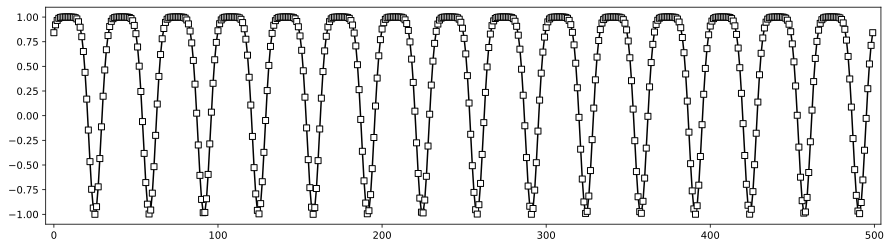

In [63]:
# import the data
N = 500

time = torch.linspace(0,30*np.pi,N)
data = torch.sin(time+torch.cos(time))

plt.figure(figsize=(15,4))
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-5,N+4])
plt.show()

In [64]:
data_test = np.float32(data)

# Create a class for the DL model

In [65]:
class rnnnet(nn.Module):
  def __init__(self):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x, h):
    
    # run through the RNN layer
    y,hidden = self.rnn(x,h)
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden.detach()

In [66]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  9 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  = 30 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet()

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X,None) # None is for empty hidden state input
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([30, 1, 1])
torch.Size([30, 1, 1])
torch.Size([1, 1, 9])


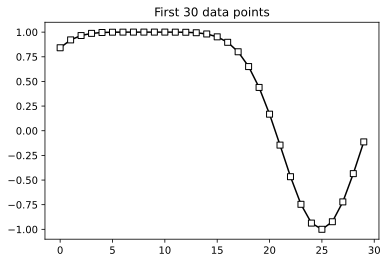

In [67]:
# is it enough data?

plt.plot(data[:seqlength],'ks-',markerfacecolor='w')
plt.title(f'First {seqlength} data points')
plt.show()

In [68]:
# test the model with some data
somedata = data[:seqlength].view(seqlength,1,1)
y = net(somedata,None)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[0][-1]

lossfun = nn.MSELoss()
lossfun(finalValue,data[seqlength].view(1,1))

tensor(0.0120, grad_fn=<MseLossBackward0>)

# Train the model and show performance

In [69]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet()
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc    = []
  hiddenstate = None

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hiddenstate = net(X,hiddenstate)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())
  
  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  
  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

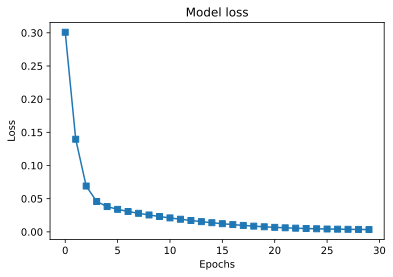

In [70]:
## let's see how the model did!

plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')

plt.show()

In [72]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_weights.pth')

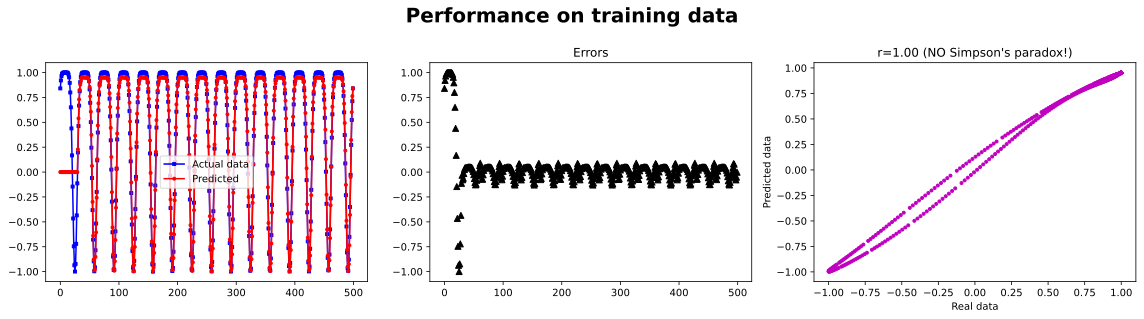

In [73]:
# now test the network!

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
hh = None
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X,hh)
  yHat[timei+seqlength] = yy[-1]
  h[timei+seqlength,:] = hh.detach()


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data',markersize=3)
ax[0].plot(yHat,'ro-',label='Predicted',markersize=3)
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:],yHat[seqlength:],'mo',markersize=3)
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (NO Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

In [74]:
# loop over time segments
print(net)

for param in net.parameters():
    print(param,param.size())
    print('-------------------------------------------------------------------------------------------------')

for name, child in net.named_children(): 
    print('name: ', name) 
    print(f'isinstance({name}, nn.Module):', isinstance(child, nn.Module))
    print('==================================================================================================')

print('================================<< rnn layer >>===============================================')
for param in net.rnn.parameters():
    print(param,param.size())
    print('----------------------------------------------------------------------------------------------')
print('================================<< out layer >>===============================================')
for param in net.out.parameters():
    print(param,param.size())
    print('----------------------------------------------------------------------------------------------')
    

for name, param in net.named_parameters():
    print('name: ', name)
    print(param)
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

rnnnet(
  (rnn): RNN(1, 9)
  (out): Linear(in_features=9, out_features=1, bias=True)
)
Parameter containing:
tensor([[-0.4929],
        [ 0.1048],
        [ 0.0352],
        [ 0.6232],
        [ 0.1924],
        [ 0.4005],
        [ 0.5858],
        [ 0.2967],
        [ 0.1197]], requires_grad=True) torch.Size([9, 1])
-------------------------------------------------------------------------------------------------
Parameter containing:
tensor([[-0.1454,  0.2434, -0.3350, -0.0739,  0.0950,  0.1066,  0.0014,  0.0912,
          0.1622],
        [-0.2058, -0.1981, -0.2819, -0.2411,  0.1166,  0.1586, -0.0772,  0.0234,
          0.2177],
        [ 0.0260, -0.0588, -0.2732,  0.0537,  0.2359,  0.1375, -0.1917, -0.0464,
         -0.2895],
        [ 0.1385,  0.2162,  0.2342, -0.1254,  0.3480,  0.1792,  0.0846,  0.0383,
         -0.0914],
        [ 0.3344, -0.0045, -0.3298, -0.1248,  0.0282,  0.2077, -0.1446, -0.1403,
          0.3521],
        [ 0.0755,  0.1959, -0.1674,  0.2441, -0.2097, -0.259

In [75]:
#print('Wih = ', net.rnn.weight_ih_l0)
#print('bih = ', net.rnn.bias_ih_l0)
Wih = net.rnn.weight_ih_l0.detach().numpy()
Wih_torch = torch.Tensor(Wih)
bih = net.rnn.bias_ih_l0.detach().numpy()
bih_torch = torch.Tensor(bih)
#print(Wih)
#print(bih)
#print('------------------------------------------------------------------------')
#print('Whh = ', net.rnn.weight_hh_l0)
#print('bhh = ', net.rnn.bias_hh_l0)
Whh = net.rnn.weight_hh_l0.detach().numpy()
Whh_torch = torch.Tensor(Whh)
bhh = net.rnn.bias_hh_l0.detach().numpy()
bhh_torch = torch.Tensor(bhh)
#print(Whh)
#print(bhh)
#print('------------------------------------------------------------------------')
#print('Who = ', net.out.weight)
#print('bho = ', net.out.bias)
Who = net.out.weight.detach().numpy()
Who_torch = torch.Tensor(Who)
bho = net.out.bias.detach().numpy()
bho_torch = torch.Tensor(bho)
#print(Who)
#print(bho)
#print('------------------------------------------------------------------------')

In [76]:
yhat_result = np.zeros(N)

for timei in range(N-seqlength):
    data_test_in = data_test[timei:timei+seqlength].reshape(1,seqlength)
    Xi = Wih @ data_test_in + bih.reshape((num_hidden,1))
    hhi = np.zeros((num_hidden,seqlength))
    
    for i in range(seqlength):
#        Whh_T = Whh.transpose()
        if i == 0:
            hhi_T = bhh.reshape((num_hidden,1))
#            hhi_T = np.zeros((num_hidden,1))
        else:
            hhi_T = Whh @ hhi[:,i-1].reshape((num_hidden,1)) + bhh.reshape((num_hidden,1))
        hhi[:,i] = hhi_T.reshape(num_hidden)
#        print('i = ', i, hhi[:,i])
#    print(hhi)
    
    hho = np.tanh(hhi + Xi)
    yhat = Who @ hho + bho
    yhat = yhat.reshape(seqlength)
    yhat_result[timei+seqlength-1] = yhat[seqlength-1]
    print(timei, 'yhat = ', yhat_result[timei+seqlength-1], 'yHat = ', yHat[timei+seqlength-1], 'y = ', data_test[timei+seqlength-1])

0 yhat =  -0.11644107065246036 yHat =  0.0 y =  -0.113125175
1 yhat =  0.2947385995788767 yHat =  0.22934332489967346 y =  0.19733584
2 yhat =  0.6350203437599817 yHat =  0.5401612520217896 y =  0.46323156
3 yhat =  0.8831430200213195 yHat =  0.7308419346809387 y =  0.66856617
4 yhat =  1.0472170284937388 yHat =  0.826704740524292 y =  0.8124639
5 yhat =  1.1468573915845186 yHat =  0.8783719539642334 y =  0.9039553
6 yhat =  1.2022109513181873 yHat =  0.9139366745948792 y =  0.95635676
7 yhat =  1.2298258675729616 yHat =  0.9387462735176086 y =  0.9829605
8 yhat =  1.2417855251838714 yHat =  0.9515158534049988 y =  0.99458236
9 yhat =  1.246033473204812 yHat =  0.9543708562850952 y =  0.99872524
10 yhat =  1.2471516429330642 yHat =  0.9526100158691406 y =  0.999817
11 yhat =  1.2473288684568742 yHat =  0.9505642056465149 y =  0.99999017
12 yhat =  1.2473389490038644 yHat =  0.9497737884521484 y =  1.0
13 yhat =  1.2473389490038644 yHat =  0.949872612953186 y =  1.0
14 yhat =  1.2473337

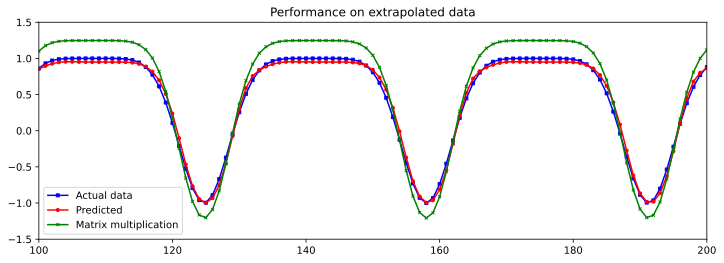

In [77]:
# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(data,'bs-',label='Actual data',markersize=3)
plt.plot(yHat,'ro-',label='Predicted',markersize=3)
plt.plot(yhat_result,'gx-',label='Matrix multiplication',markersize=3)
plt.ylim([-1.5,1.5])
plt.xlim([100,200])
plt.legend()
plt.title('Performance on extrapolated data')
plt.show()

'/content'